In [8]:
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path

import matplotlib.pyplot as plt
import arviz as az
import os
import tqdm

import sys
sys.path.append('../scripts')

from parameter_estimation import BivariateBeta

## Stan Model

For using the following notebook, it is necessary to set the `cmdstan` path correctly. 

In [2]:
set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

Then, we can proceed the compilation.

In [3]:
stanfile = os.path.join('..', 'scripts', 'bivariate-beta-model.stan')
model = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS':'true'})

INFO:cmdstanpy:found newer exe file, not recompiling


Generating the data

In [4]:
alpha = np.array([1,1,1,1])
n = 50
U = np.random.dirichlet(alpha, size=n)
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]
XY = np.column_stack([X,Y])

a = np.array([1,1,1,1])
b = np.array([1,1,1,1])

data = {'n': n, 'xy': XY, 'a': a, 'b': b, 'tolerance': 1e-8}

In [5]:
model_fit = model.sample(data=data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [6]:
print(model_fit.diagnose())

Processing csv files: /tmp/tmp8lqw_h40/bivariate-beta-model-20220604214749_1.csv, /tmp/tmp8lqw_h40/bivariate-beta-model-20220604214749_2.csv, /tmp/tmp8lqw_h40/bivariate-beta-model-20220604214749_3.csv, /tmp/tmp8lqw_h40/bivariate-beta-model-20220604214749_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [7]:
model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,13.0,0.0350,1.40,11.00,14.0,15.0,1700.0,3.0,1.0
alpha[1],1.1,0.0051,0.24,0.72,1.1,1.5,2180.0,4.0,1.0
alpha[2],1.1,0.0052,0.24,0.71,1.1,1.5,2063.0,3.8,1.0
alpha[3],1.2,0.0057,0.25,0.82,1.2,1.7,1988.0,3.7,1.0
alpha[4],1.3,0.0055,0.25,0.88,1.3,1.7,2161.0,4.0,1.0


In [10]:
inf_data = az.from_cmdstanpy(model_fit)

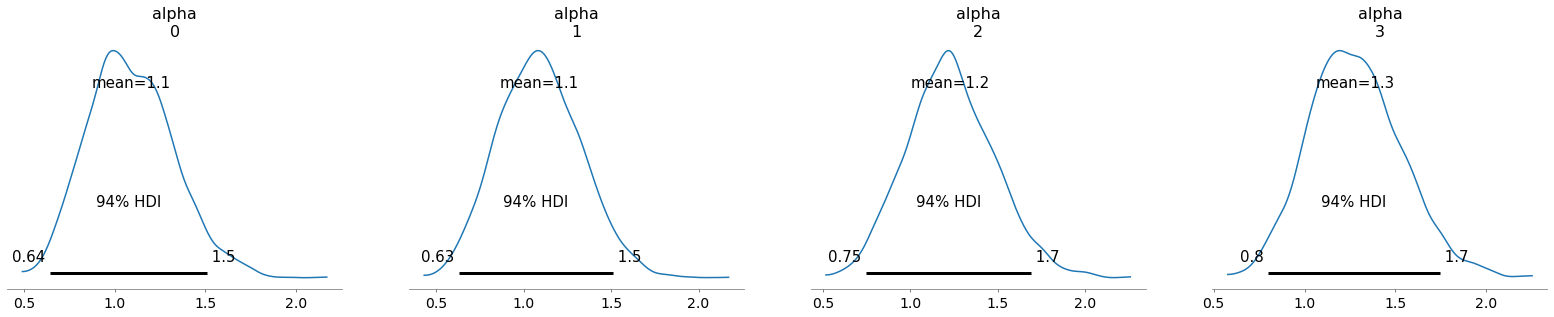

In [14]:
az.plot_posterior(inf_data, var_names='alpha')
plt.show()